In [1]:
import os
# For CUDA GPU Debug Mode
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset
from tqdm import tqdm

mode = 'notebook' #notebook, colab
render = 'image' #image, graph

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

if mode == 'colab':
    import cufflinks as cf
    cf.go_offline()
    init_notebook_mode(connected=False)

    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
          <script src="/static/components/requirejs/require.js"></script>
          <script>
            requirejs.config({
              paths: {
                base: '/static/base',
                plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
              },
            });
          </script>
          '''))

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

if render == 'image':
    pio.renderers.default = "png"




In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Bigram Model (Frequency Distribution) - Name Generation

We will use a frequency distribution table to compute the probability of an output (next) character given an input character. 

## Load data

In [5]:
file = os.path.join('data', 'names.txt')
with open(file, 'r') as f:
    names = f.read()
    words = names.split('\n')
print(len(words))
print(words[:10])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


## Create bigram for each character

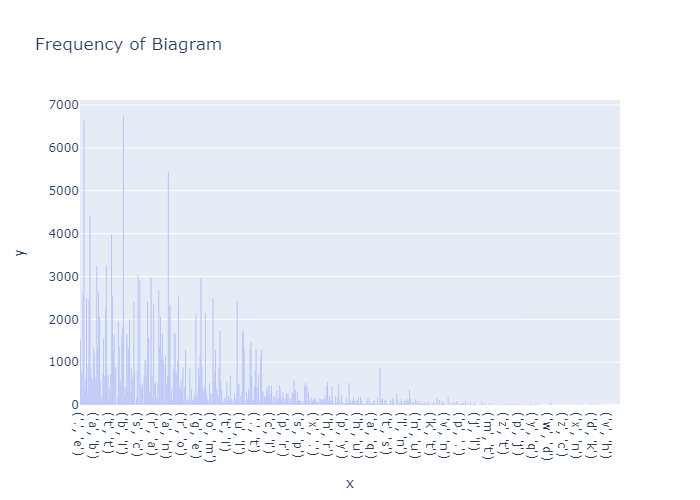

In [6]:
delimiter_token = '.'
bigrams = {}
for w in words:
    chr = [delimiter_token] + list(w) + [delimiter_token]
    for character1, character2 in zip(chr, chr[1:]):
        bigram = (character1, character2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
keys = bigrams.keys()

if mode == 'colab':
    configure_plotly_browser_state()
fig = px.bar(x=[str(key) for key in keys], y=[bigrams[key] for key in keys], title='Frequency of Biagram')
fig.show()
del keys

## Create 2D-Array that contains the count of each bigram

Total characters: 27


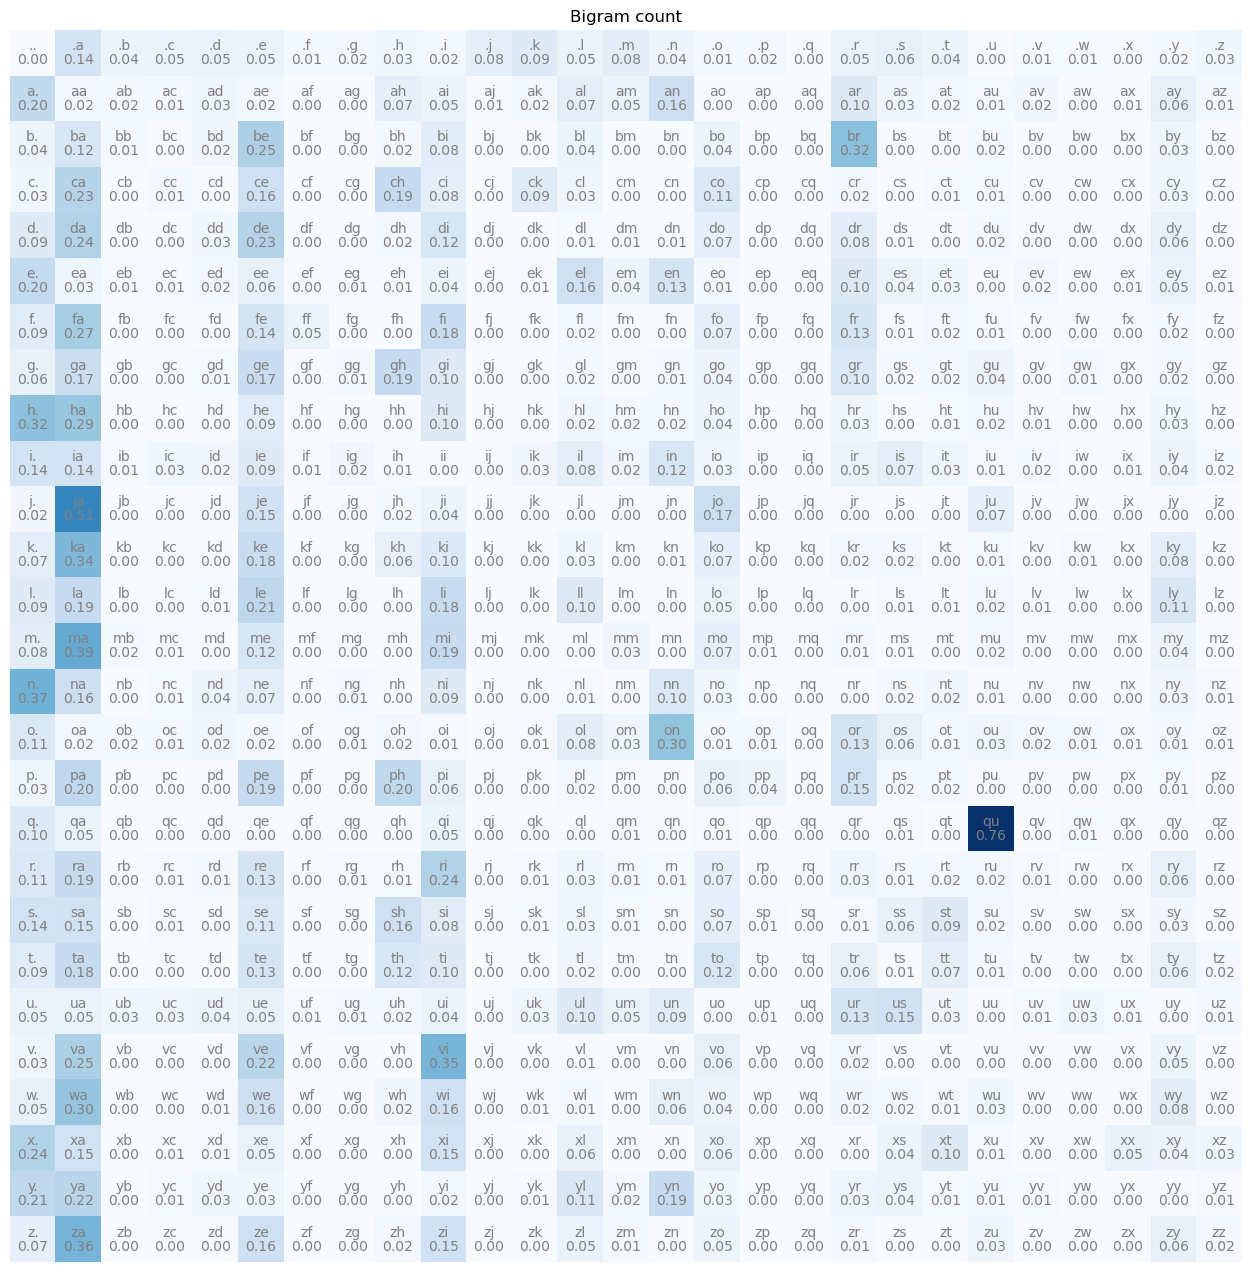

In [7]:
characters = [delimiter_token] + sorted(list(set(''.join(words))))
characters_to_index = {c: i for i, c in enumerate(characters)}
print(f"Total characters: {len(characters)}")
dictionary = torch.zeros((len(characters), len(characters)), dtype=torch.float64)

# Add frequency to dictionary
for bigram in bigrams:
    dictionary[characters_to_index[bigram[0]], characters_to_index[bigram[1]]] = bigrams[bigram]

# Create probability of getting a next character token given a character
dictionary /= dictionary.sum(1, keepdim=True) # Sum acroess each row
for i in range(dictionary.shape[0]):
    total_probability_each_row = dictionary[i].sum().item()
    # Total sum of each row must be approximately equal to 1
    assert (total_probability_each_row == 0) or (0.99 <= total_probability_each_row <= 1.1)

plt.figure(figsize=(16, 16))
plt.title("Bigram count")
plt.imshow(dictionary, cmap='Blues')
for i in range(dictionary.shape[0]):
    for j in range(dictionary.shape[1]):
        plt.text(j, i, characters[i] + characters[j], ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{dictionary[i, j].item():.2f}', ha="center", va="top", color="gray")
plt.axis('off')
plt.show()

## Randomly generate names from the probability distribution table

In [8]:
output_names = []

for _ in range(20):
    current_character = characters_to_index[delimiter_token] # First character is always delimiter
    name = []
    name.append(characters[current_character])
    while True:
        probabilities = dictionary[current_character] # Get the row of probability of next character for the current character
        # Predict next character based on probability distribution
        current_character = torch.multinomial(probabilities, num_samples=1, replacement=True).item()
        if current_character == characters_to_index[delimiter_token]: # break loop when end token is reached
            name.append(characters[current_character])
            break
        else:
            name.append(characters[current_character])
    output_names.append(''.join(name))

print('\n'.join(output_names))

.nelil.
.biayamees.
.rrbentah.
.kodee.
.jenn.
.an.
.h.
.li.
.onya.
.dnya.
.ce.
.kwee.
.kenose.
.jabeleil.
.dfsce.
.a.
.mianakyar.
.jublaliseronigiviamo.
.ta.
.reaicaanan.


## Compute Total Likelihood of bigrams in the dataset

In [9]:
# Total probability of bigrams of first three words
total_probability_dataset = 1.0
for word in words[:3]:
    word = delimiter_token + word + delimiter_token
    for ch1, ch2 in zip(word, word[1:]):
        prob = dictionary[characters_to_index[ch1], characters_to_index[ch2]].item()
        total_probability_dataset *= prob

print(f"Total probability of the first three words is:", total_probability_dataset)

# Total probability of bigrams of entire dataset
total_probability_dataset = 1.0
for word in words:
    word = delimiter_token + word + delimiter_token
    for ch1, ch2 in zip(word, word[1:]):
        prob = dictionary[characters_to_index[ch1], characters_to_index[ch2]].item()
        total_probability_dataset *= prob

print(f"Total probability of the dataset is:", total_probability_dataset)

Total probability of the first three words is: 1.4309086433011188e-17
Total probability of the dataset is: 0.0


**Since we are multiplying the probability of all bigrams in the dataset, the value becomes very small. Therefore, our computer due to floating point precision produces the output as zero. As a result, we prefer to work with the log of probability instead of the probability itself.**

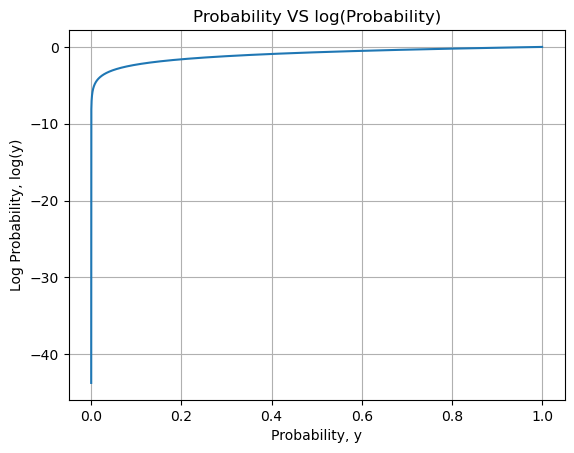

In [10]:
y = np.arange(1e-19, 1, 0.0001)
log_y = np.log(y)
plt.figure()
plt.title("Probability VS log(Probability)")
plt.xlabel("Probability, y")
plt.ylabel("Log Probability, log(y)")
plt.plot(y, log_y)
plt.grid()
plt.show()

**When the probability is 1, log of the probability is zero. As the probability decreases, the log of the probability becomes more and more negative. The log of zero is negative infinity**

In [11]:
# Log Likelihood of entire dataset
total_log_likelihood_dataset = 0.0
for word in words:
    word = delimiter_token + word + delimiter_token
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        total_log_likelihood_dataset += log_likelihood
print(f"Total log probability of the dataset is:", total_log_likelihood_dataset)

Total log probability of the dataset is: tensor(-559873.5896, dtype=torch.float64)


In [12]:
# Log Likelihood of output
total_log_likelihood_dataset = 0.0
for word in output_names:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        total_log_likelihood_dataset += log_likelihood
print(f"Total log probability of the output is:", total_log_likelihood_dataset)

Total log probability of the output is: tensor(-324.6966, dtype=torch.float64)


**The closer the log of likelihood is to zero, the better is the model. We use this log likelihood to compute the loss of a model. But for a model, we want the minimum loss to be zero and as the value increases, it would mean that the model is performing worse. So, to solve this problem we compute the negative of the log likelihood. In that case, as the model becomes worse the value of log increases to positive infinity and as the model becomes better the loss decreases to zero. This is known as the negative log likelihood.**

## Loss (Average Negative Log Likelihood)

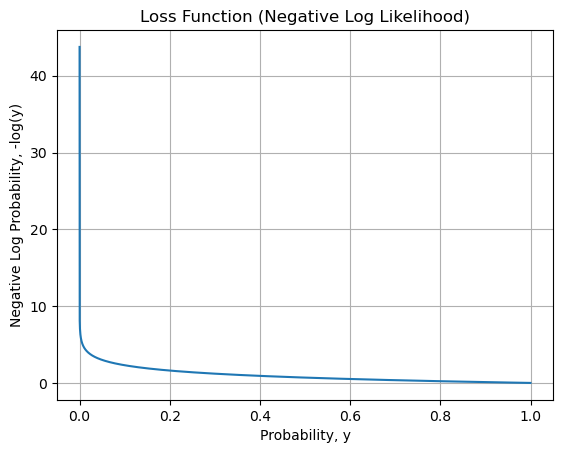

In [13]:
y = np.arange(1e-19, 1, 0.0001)
negative_log_y = -np.log(y)
plt.figure()
plt.title("Loss Function (Negative Log Likelihood)")
plt.xlabel("Probability, y")
plt.ylabel("Negative Log Probability, -log(y)")
plt.plot(y, negative_log_y)
plt.grid()
plt.show()

In [14]:
# Loss of entire dataset
negative_log_likelihood_dataset = 0.0
for word in words:
    word = delimiter_token + word + delimiter_token
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
print(f"Total loss (negative log likelihood) of the dataset is:", negative_log_likelihood_dataset)

Total loss (negative log likelihood) of the dataset is: tensor(559873.5896, dtype=torch.float64)


In [15]:
# Loss of output
negative_log_likelihood_dataset = 0.0
for word in output_names:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
print(f"Total log probability of the output is:", negative_log_likelihood_dataset)

Total log probability of the output is: tensor(324.6966, dtype=torch.float64)


**Since the entire dataset has more bigrams than the output, it is showing a higher loss. To compare loss of both - dataset and output, we need to normalize it so that we can compare both the outputs**

In [16]:
# Loss of entire dataset
negative_log_likelihood_dataset = 0.0
bigram_count = 0
for word in words:
    word = delimiter_token + word + delimiter_token
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1

negative_log_likelihood_dataset /= bigram_count
print(f"Total loss (average negative log likelihood) of the dataset is:", negative_log_likelihood_dataset)

Total loss (average negative log likelihood) of the dataset is: tensor(2.4540, dtype=torch.float64)


In [17]:
# Loss of output
negative_log_likelihood_dataset = 0.0
bigram_count = 0
for word in output_names:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1
if bigram_count > 0:
    negative_log_likelihood_dataset /= bigram_count
print(f"Total log probability of the output is:", negative_log_likelihood_dataset)

Total log probability of the output is: tensor(2.4786, dtype=torch.float64)


**Now we can compare the loss of both - dataset and output. We can see that our model has a loss that is near the average loss of the dataset. During training, we try to minimize the average negative log likelihood of the model.**

In [18]:
# Check the probability of a name based on our probability distribution
# Loss of output
negative_log_likelihood_dataset = 0.0
bigram_count = 0
for word in ['zohair']:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1
negative_log_likelihood_dataset /= bigram_count
print(f"Total log probability of the output is:", negative_log_likelihood_dataset)

Total log probability of the output is: tensor(2.8401, dtype=torch.float64)


**The loss of the above word is 2.8 which is greater than the loss of the entire dataset. So, according to the probability distribution of our dataset, the above name is not very likely. But if we had a different dataset, the likelihood of this name would change based on it.**

In [19]:
# Check the probability of a name based on our probability distribution
# Loss of output
negative_log_likelihood_dataset = 0.0
bigram_count = 0
for word in ['bacqj']:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1
negative_log_likelihood_dataset /= bigram_count
print(f"Total log probability of the output is:", negative_log_likelihood_dataset)

Total log probability of the output is: tensor(inf, dtype=torch.float64)


**We can see that for the name 'bacqj' above - the loss is infinity. That is because, in our dataset we do not have the following character sequence - qj. Therefore, the probability of this sequence is zero. The log of zero is infinity. So, we get a losss of infinity. To solve this problem, we add a small offset so that no probability is zero.**

**This is known as model smoothing. Instead of adding probability, we can by default - set the count of each bigram to 1.**

In [20]:
dictionary += 1e-9

In [21]:
# Check the probability of a name based on our probability distribution
# Loss of output
negative_log_likelihood_dataset = 0.0
bigram_count = 0
for word in ['bacqj']:
    for ch1, ch2 in zip(word, word[1:]):
        log_likelihood = -torch.log(dictionary[characters_to_index[ch1], characters_to_index[ch2]])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1
negative_log_likelihood_dataset /= bigram_count
print(f"Total log probability of the output is:", negative_log_likelihood_dataset)

Total log probability of the output is: tensor(8.2205, dtype=torch.float64)


# Bigram Model (Neural Network) - Name Generation

- The weight of the network will technically contain the probability distribution of the bigrams.

- We will create a test and train dataset of the bigrams where the inputs will be a character sequence of length 'n' and the output label 'y' will be the next character that the network should predict based on the input.

.  ->  e
e  ->  m
m  ->  m
m  ->  a
a  ->  .
tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22], device='cuda:0')
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9], device='cuda:0')
torch.Size([228146, 27])


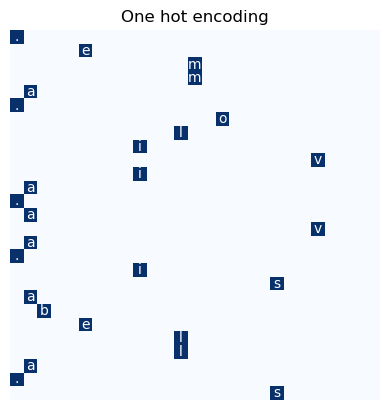

In [22]:
# Create dataset with class and label
xs, ys = [], []
count = 0
for word in words:
    chs = [delimiter_token] + list(word) + [delimiter_token]
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(characters_to_index[ch1])
        ys.append(characters_to_index[ch2])
        if count == 0:
            print(ch1, ' -> ', ch2)
    count += 1

xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)
print(xs[:10])
print(ys[:10])

# Perform one hot encoding of the inputs
xs = F.one_hot(xs, num_classes=len(characters)).float().to(device)
print(xs.shape)
plt.figure()
plt.title("One hot encoding")
plt.imshow(xs[:27].cpu(), cmap='Blues')
for i in range(27):
    pos = torch.where(xs[i] == 1)[0].item()
    plt.text(pos, i, characters[pos], ha="center", va="center", color="white")
plt.axis('off')
plt.show()

## Create a neuron where the weight follows a normal distribution

torch.Size([228146, 1])


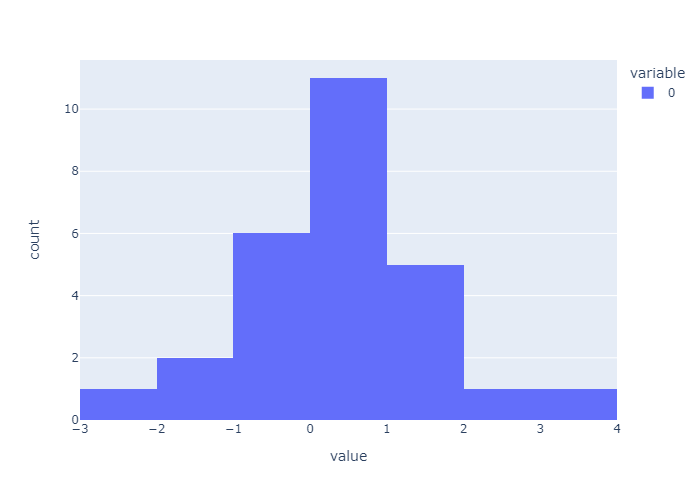

In [23]:

W = torch.randn((len(characters), 1)).to(device) # 27 inputs: One hot encoded vector for input character, outputs: 1 output

# Generate output for all outputs
y_outputs = xs @ W
print(y_outputs.shape)

if mode == 'colab':
    configure_plotly_browser_state()
fig = px.histogram(W.reshape((-1,)).cpu())
fig.show()

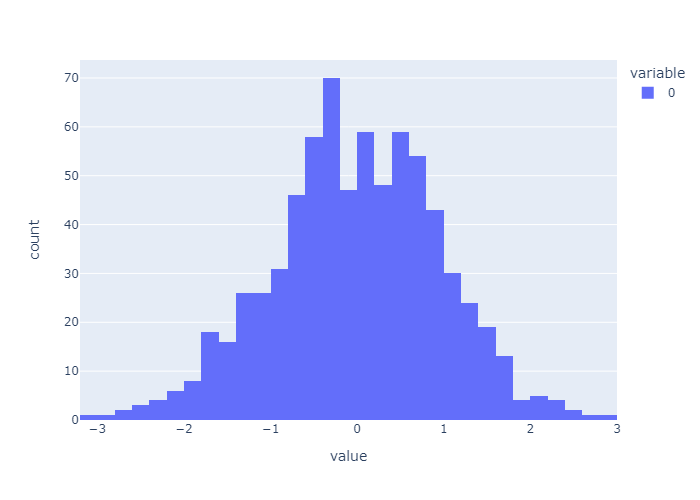

torch.Size([228146, 27])
tensor([[0.0676, 0.0237, 0.0152,  ..., 0.0121, 0.0178, 0.0040],
        [0.1163, 0.0134, 0.0218,  ..., 0.0313, 0.0077, 0.0273],
        [0.0243, 0.0383, 0.0076,  ..., 0.0165, 0.1495, 0.0461],
        ...,
        [0.0465, 0.0063, 0.0131,  ..., 0.0234, 0.0236, 0.0488],
        [0.0078, 0.0035, 0.0225,  ..., 0.0136, 0.0829, 0.0297],
        [0.0028, 0.0704, 0.1378,  ..., 0.0377, 0.0129, 0.0299]],
       device='cuda:0')


In [24]:
# Create a neuron where the weight follows a normal distribution

# 27 inputs: One hot encoded vector for input character, 27 outputs: Each output is the probability of each character.
# This weight of size (len(characters) x len(characters)) is similar to the probability distribution table that we had above.
# But the values in these weights are not just between 0 and 1. Therefore, we can consider each value as 'log count' and when we 
# take the exponent of this value, we will get the frequency of each character.
W = torch.randn((len(characters), len(characters))).to(device)

if mode == 'colab':
    configure_plotly_browser_state()
fig = px.histogram(W.reshape((-1,)).cpu())
fig.show()

# Generate output for all outputs
logits = xs @ W
print(logits.shape)

counts = logits.exp()
output_probabilities = counts/counts.sum(1, keepdim=True)
print(output_probabilities)

**The log-count (also called logits) provide us the log of the frequency of each output character given an input character. When we take the exponent of this value, we get the frequency (or count) of each output character provided an input character. Based on this frequency, we can compute the probability of each output character given an input character. We can use that probability to predict the next character (like frequency distribution table above) and finally calculate the loss to optimize the weights of the network.**

## Randomly generate names from the untrained neural network

In [25]:
output_names = []
W = torch.randn((len(characters), len(characters))).to(device)
negative_log_likelihood_dataset = 0.0
bigram_count = 0

for _ in range(20):
    current_character = characters_to_index[delimiter_token] # First character is always delimiter
    name = []
    name.append(characters[current_character])
    while True:
        # Get the row of probability of next character for the current character
        one_hot_encoded_character = F.one_hot(torch.tensor(current_character), num_classes=len(characters)).float().to(device)
        x = one_hot_encoded_character.reshape((1, -1))
        logits = x @ W
        counts = logits.exp()
        probabilities = counts/counts.sum(1, keepdim=True)

        # Predict next character based on probability distribution
        current_character = torch.multinomial(probabilities[0], num_samples=1, replacement=True).item()

        # Calulate the loss
        log_likelihood = -torch.log(probabilities[0, current_character])
        negative_log_likelihood_dataset += log_likelihood
        bigram_count += 1

        if current_character == characters_to_index[delimiter_token]: # break loop when end token is reached
            name.append(characters[current_character])
            break
        else:
            name.append(characters[current_character])
    output_names.append(''.join(name))

negative_log_likelihood_dataset /= bigram_count
print(f"The loss is {negative_log_likelihood_dataset:.4f}")
print('\n'.join(output_names))

The loss is 2.8970
.werzqgmfqi.
..
.zooebvarejq.
.pdbrnhxafcfuziathmkinelkyucyuokqjhvwhbynpucgamquv.
.plkqghrnniozc.
.wyulgswflwaudijzppwglmfqxkxmfublztbcfmvkgnszwufheblpcrzifo.
.waklaksehfuubmargfzppiqo.
.pdnhoo.
.txwdsrufexwglknnbxkkqimhvpdbmifdiiljzizrztgrngy.
.tnevkmiompxapwpifcklkiisfqelfcamklk.
.qzakau.
.owkhqicfdbyotayf.
.pcflkftkzwftnxnmftumktkfflkbmqwylrgycdblkepwy.
.oebthvqlgszzljdlkwfylgsdyqishynmkflcjzosvcdonztekmkckyckpiqijixopvrawfqjawpdglkqjvcqkbdblkipvzsoso.
.thruyvchvkvlsgsbaevvbiynrzq.
.qnpdbhzcsdlzpmkxzkibizq.
.pvcmfyvzciuubirswnpne.
.tnvpegsevcfxpnrgszaithvctvkbcfcmhvrhrcantxzcfldedzdffo.
.y.
.prubdfcakmplnj.


## Train the neural network

In [26]:
# Split to train and test set
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Network params
W = torch.randn((len(characters), len(characters)), requires_grad=True).to(device)
W.retain_grad()
batch_size = 32
epochs = 10000
learning_rate = 0.1

first_loss = 0

for i in tqdm(range(epochs)):
    # Set initial gradient of weights to zero
    W.grad = None
    
    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    x, y = x_train[idx], y_train[idx]

    # Predict output
    logits = x @ W
    counts = logits.exp()
    probabilities = counts/counts.sum(1, keepdim=True)

    # Calulate the loss
    batch_loss = -torch.log(probabilities[np.arange(y.shape[0]), y])/y.shape[0]
    
    loss = batch_loss.sum()
    
    if i == 0:
        first_loss = loss.item()
        
    # Calculate the gradients of the weight
    loss.backward()
    
    # Update the weights
    W.data += learning_rate * (-W.grad)

print(f"Initial loss before training the network: {first_loss:.4f}")
print(f"Final loss after training the network for all epochs: {loss.item():.4f}")

torch.Size([182516, 27]) torch.Size([182516]) torch.Size([45630, 27]) torch.Size([45630])


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:50<00:00, 197.02it/s]

Initial loss before training the network: 3.7749
Final loss after training the network for all epochs: 2.4061


## Get the test loss

In [27]:
with torch.no_grad():
    # Predict output
    logits = x_test @ W
    counts = logits.exp()
    probabilities = counts/counts.sum(1, keepdim=True)

    # Calulate the loss
    batch_loss = -torch.log(probabilities[np.arange(y_test.shape[0]), y_test])/y_test.shape[0]

    loss = batch_loss.sum()
    print(f"The test loss is {loss.item()}")

The test loss is 2.7190375328063965


## Generate names

In [29]:
output_names = []

for _ in range(20):
    current_character = characters_to_index[delimiter_token] # First character is always delimiter
    name = []
    name.append(characters[current_character])
    while True:
        # Get the row of probability of next character for the current character
        one_hot_encoded_character = F.one_hot(torch.tensor(current_character), num_classes=len(characters)).float().to(device)
        x = one_hot_encoded_character.reshape((1, -1))
        
        with torch.no_grad():
            logits = x @ W
            counts = logits.exp()
            probabilities = counts/counts.sum(1, keepdim=True)

            # Predict next character based on network output
            #current_character = torch.argmax(probabilities[0]).item()
            current_character = torch.multinomial(probabilities[0], num_samples=1, replacement=True).item()
#         print(characters[current_character])
        if current_character == characters_to_index[delimiter_token]: # break loop when end token is reached
            name.append(characters[current_character])
            break
        else:
            name.append(characters[current_character])
    output_names.append(''.join(name))
print('\n'.join(output_names))

.fuanera.
.a.
.anindaylfyarenerara.
.raneeyzamon.
.zyan.
.kcfhah.
.lilemahka.
.madagxonairia.
.pmen.
.maranyaikhekcjaijaq.
.uike.
.an.
.albin.
.ngimayacolttglen.
.bhaluejsavicaniealycjondennken.
.jwjas.
.j.
.zwczspbrlyaage.
.mljavissaylxta.
.r.


# N-Gram Model (Neural Network) - Name Generation

Using Neural Networks, we can provide 'n' characters as input to predict the next character as output. This is done using Multi-Layered Perceptron (MLP). 

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]], device='cuda:0')
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9], device='cuda:0')
torch.Size([228146, 3, 27])


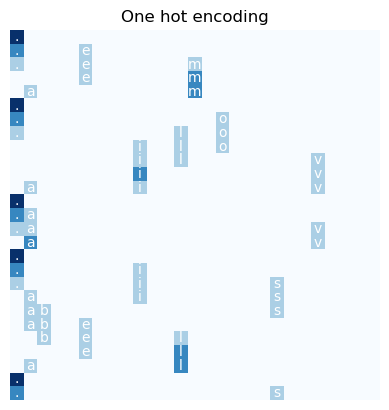

In [30]:
# Create dataset with class and label
block_size = 3 #Total characeters per input
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'
    
    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]

xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)
print(xs[:10])
print(ys[:10])

# Perform one hot encoding of the inputs
xs = F.one_hot(xs, num_classes=len(characters)).float().to(device)
print(xs.shape)


plt.figure()
plt.title("One hot encoding")
image = torch.zeros((27, 27)).float()

for i in range(image.shape[0]):
    image[i] += xs[i].cpu().sum(0)
    
plt.imshow(image, cmap='Blues')

for i in range(image.shape[0]):
    positions = torch.where(image[i] > 0)[0]
    for pos in positions:
        plt.text(pos, i, characters[pos], ha="center", va="center", color="white")
plt.axis('off')
plt.show()

## Create Embedding (Lookup) Table

In [31]:
embedding_size = 2
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

with torch.no_grad():
    print(lookup_table[characters_to_index['a']])


tensor([ 0.7144, -0.0429], device='cuda:0', requires_grad=True)


**Since this lookup table contains a vector of weights for each character, we can discard the one-hot encoding and use this instead. It will act as the first layer of the network and we can train these weights using the loss function.**

In [32]:
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'
    
    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]

with torch.no_grad():
    xs = lookup_table[xs].to(device)
ys = torch.tensor(ys).to(device)

print(xs.shape)
print(xs[:2])

torch.Size([228146, 3, 2])
tensor([[[ 0.2363,  1.7225],
         [ 0.2363,  1.7225],
         [ 0.2363,  1.7225]],

        [[ 0.2363,  1.7225],
         [ 0.2363,  1.7225],
         [-2.1099,  0.6717]]], device='cuda:0')


## Create Network

In [33]:
W1 = torch.randn((block_size * embedding_size, 100), requires_grad=True).to(device)
b1 = torch.randn(100, requires_grad=True).to(device)

with torch.no_grad():
    out1 = xs.view(-1, block_size * embedding_size) @ W1 + b1
    activated_output = torch.tanh(out1)
    print(activated_output.shape)

torch.Size([228146, 100])


In [34]:
W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
b2 = torch.randn(len(characters), requires_grad=True).to(device)

with torch.no_grad():
    out2 = activated_output @ W2 + b2
    logits = torch.tanh(out2)
    print(logits.shape)
    counts = logits.exp()
    probabilities = counts / counts.sum(1, keepdim=True)
    print(probabilities.shape)
    print(probabilities[0].sum())

torch.Size([228146, 27])
torch.Size([228146, 27])
tensor(1., device='cuda:0')


## Train the network

In [35]:
# Create embedding table
embedding_size = 2
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'
    
    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)
        
# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# Network parameters

W1 = torch.randn((block_size * embedding_size, 100), requires_grad=True).to(device)
b1 = torch.randn(100, requires_grad=True).to(device)

W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
b2 = torch.randn(len(characters), requires_grad=True).to(device)

batch_size = 32
epochs = 10_000
learning_rate = 0.1

parameters = [lookup_table, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    p.retain_grad()
    total_params += p.nelement()
print(f"Total parameters: {total_params}")

# Train the network
first_loss = 0

for i in tqdm(range(epochs)):
    # Set initial gradient of weights and biases to zero
    for p in parameters:
        p.grad = None
    
    
    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    # Inputs must be converted to embeddings just before the forward pass to preserve gradients
    x, y = lookup_table[x_train[idx]], y_train[idx]

    # Predict output
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y)
    
    if i == 0:
        first_loss = loss.item()
        
    # Calculate the gradients of the weight
    loss.backward()
    
    # Update the parameters
    lookup_table.data += learning_rate * (-lookup_table.grad)
    W1.data += learning_rate * (-W1.grad)
    b1.data += learning_rate * (-b1.grad)
    W2.data += learning_rate * (-W2.grad)
    b2.data += learning_rate * (-b2.grad)
    

print(f"Initial loss before training the network: {first_loss:.4f}")
print(f"Final loss after training the network for all epochs: {loss.item():.4f}")

torch.Size([182516, 3]) torch.Size([182516]) torch.Size([45630, 3]) torch.Size([45630])
Total parameters: 3481


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:53<00:00, 186.29it/s]

Initial loss before training the network: 18.8108
Final loss after training the network for all epochs: 2.6143


**Since we are calulating gradient for the lookup table, the input vectors must be converted to embedding just before it is passed through the first layer. Otherwise, torch will not be able to calcuate the gradient of the lookup table as it keeps a computation graph**

## Get the test loss

In [36]:
with torch.no_grad():
    # Predict output
    x = lookup_table[x_test]
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y_test)
    print(f"The test loss is {loss.item()}")

The test loss is 2.6188502311706543


## Generate names

In [38]:
output_names = []

for _ in range(20):
    current_characters = [characters_to_index[delimiter_token] for _ in range(block_size)] # First n character is always delimiter
    name = []
    name.append(characters[current_characters[0]])
    while True:
        
        with torch.no_grad():
            x = lookup_table[current_characters]
            out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
            logits = out1 @ W2 + b2
            counts = logits.exp()
            probabilities = counts/counts.sum(1, keepdim=True)

            # Predict next character based on network output
            #current_character = torch.argmax(probabilities[0]).item()
            current_character = torch.multinomial(probabilities[0], num_samples=1, replacement=True).item()
            current_characters = current_characters[1:] +  [current_character]
#         print(characters[current_character])
            if current_character == characters_to_index[delimiter_token]: # break loop when end token is reached
                name.append(characters[current_character])
                break
            else:
                name.append(characters[current_character])
    output_names.append(''.join(name))
print('\n'.join(output_names))

.javan.
.mafaa.
.jodkeriro.
.aluni.
.marse.
.arusbyanna.
.ratyah.
.agvacehiebte.
.may.
.jatianm.
.birsepynavia.
.fareen.
.telania.
.ano.
.jira.
.auzoipebtamial.
.loea.
.layar.
.alila.
.nosyea.


## Visualize the characters based on embedding vectors

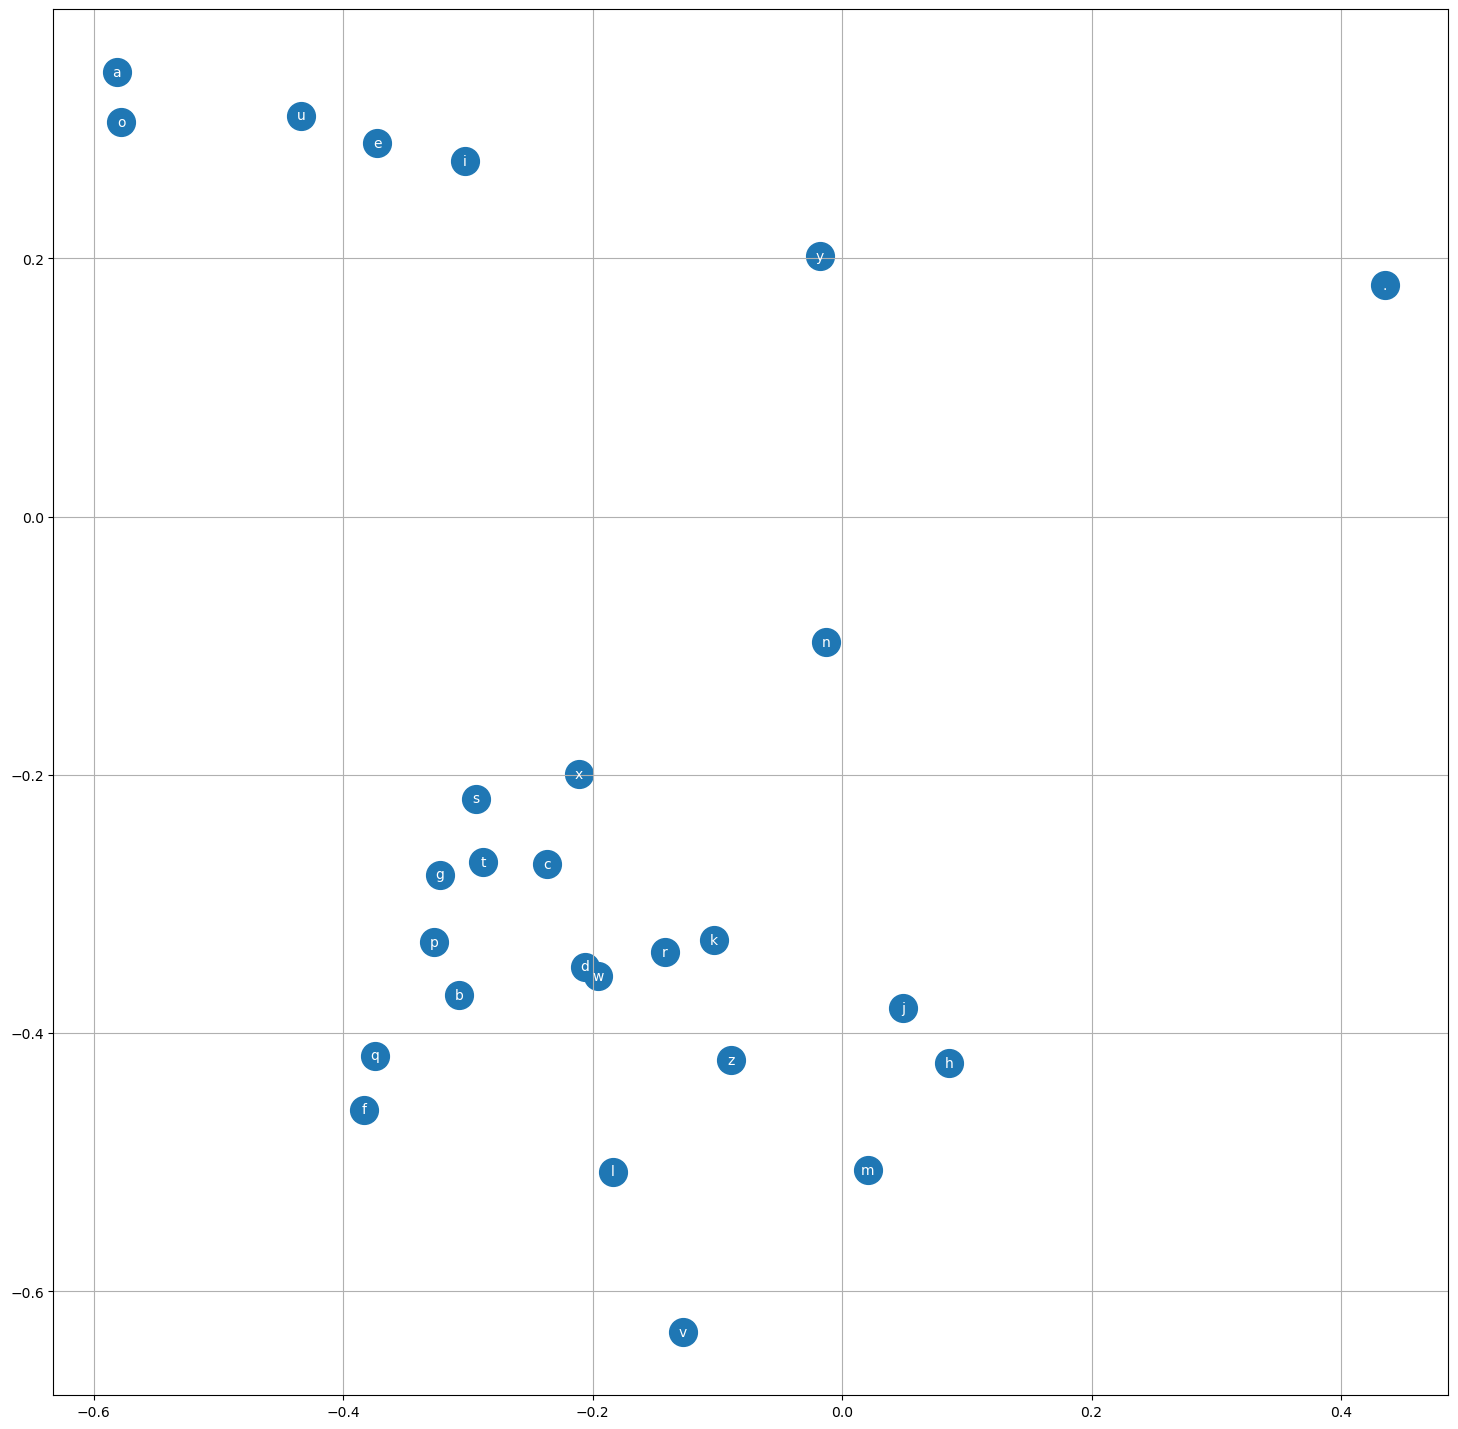

In [39]:
with torch.no_grad():
    plt.figure(figsize=(18, 18))
    plt.scatter(lookup_table[:, 0].cpu(), lookup_table[:, 1].cpu(), s=400)
    for i in range(lookup_table.shape[0]):
        plt.text(lookup_table[i, 0].item(), lookup_table[i, 1].item(), characters[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.show()

From the above graph we can see that the characters are clustered into different groups. For example, the vowels are clustered together as they are semantically similar. The plot contains the data from the lookup table. Since we trained the lookup table, the embedding weights were updated for the characters.

# Determining the learning rate

We will create different learning rates between 0 and 1 and use them in each epoch of optimization. We will plot the loss for each learning rate

torch.Size([182516, 3]) torch.Size([182516]) torch.Size([45630, 3]) torch.Size([45630])
Total parameters: 3481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.02it/s]


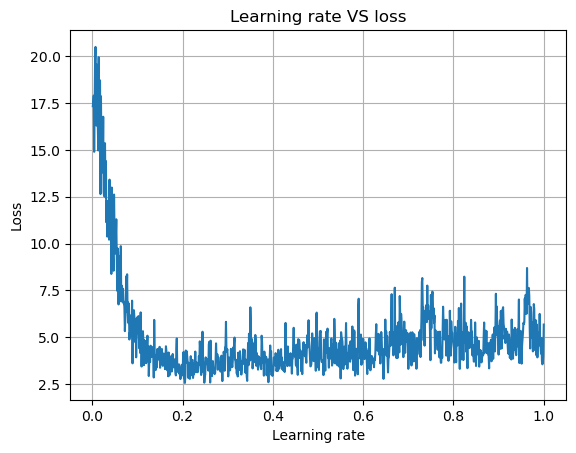

In [40]:
learning_rates = torch.linspace(1e-3, 1, 1000)
losses = []

# Create embedding table
embedding_size = 2
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'
    
    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)
        
# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# Network parameters

W1 = torch.randn((block_size * embedding_size, 100), requires_grad=True).to(device)
b1 = torch.randn(100, requires_grad=True).to(device)

W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
b2 = torch.randn(len(characters), requires_grad=True).to(device)

batch_size = 32

parameters = [lookup_table, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    p.retain_grad()
    total_params += p.nelement()
print(f"Total parameters: {total_params}")

# Train the network

for i in tqdm(range(len(learning_rates))):
    # Set initial gradient of weights and biases to zero
    for p in parameters:
        p.grad = None
    
    
    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    # Inputs must be converted to embeddings just before the forward pass to preserve gradients
    x, y = lookup_table[x_train[idx]], y_train[idx]

    # Predict output
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y)
    losses.append(loss.item())
        
    # Calculate the gradients of the weight
    loss.backward()
    
    # Update the parameters
    for p in parameters:
        p.data += learning_rates[i] * (-p.grad)
    

plt.figure()
plt.title("Learning rate VS loss")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.plot(learning_rates, losses)
plt.grid()
plt.show()

**We can see that when the learning rate is too low, the loss decreases slowly. However, if the learning rate is too high the loss fluctuates a lot. So, the ideal learning rate here is somewhere between 0.1 and 0.2.**

**One good approach is to set a good learning rate and reduce it gradually as time passes. This is known as learning rate decay.**


# Determining the Block Size

We will create different block sizes between 2 to 20 and see how the loss changes as the block size of the network changes

BS: 20: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.10it/s]


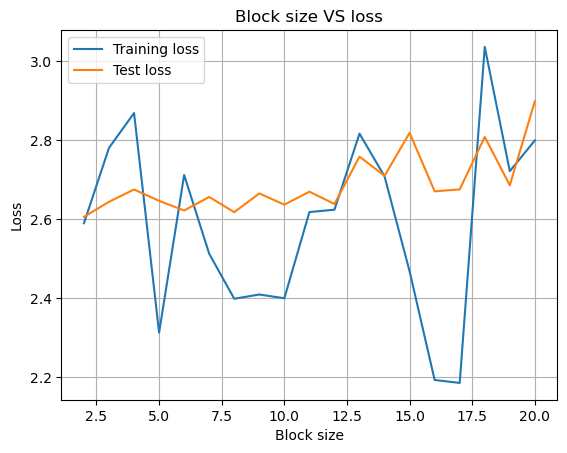

In [41]:
block_sizes = torch.arange(2, 21, 1)
test_losses = []
train_losses = []

for i in range(block_sizes.shape[0]):
    block_size = block_sizes[i]

    # Create embedding table
    embedding_size = 2
    lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

    # Create dataset
    xs, ys = [], []
    count = 0
    for word in words:
        # Create sequences of 'n' inputs as x and the next character as output 'y'

        # Initially all characters in input will be delimiter token and output will be the 
        # first character of the word
        context = [characters_to_index[delimiter_token] for _ in range(block_size)]
        for c in word + delimiter_token:
            output_character = characters_to_index[c]
            xs.append(context)
            ys.append(output_character)
            # Add the current character to context sequence and the next character will be the output
            context = context[1:] + [output_character]


    xs = torch.tensor(xs).to(device)
    ys = torch.tensor(ys).to(device)

    # Split train and test dataset
    indices = np.arange(xs.shape[0])
    np.random.shuffle(indices)
    train_split=0.8
    split_idx = int(xs.shape[0]*train_split)
    x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
    


    # Network parameters

    W1 = torch.randn((block_size * embedding_size, 100), requires_grad=True).to(device)
    b1 = torch.randn(100, requires_grad=True).to(device)

    W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
    b2 = torch.randn(len(characters), requires_grad=True).to(device)

    learning_rate = 0.1
    batch_size = 32
    epochs = 10_000

    parameters = [lookup_table, W1, b1, W2, b2]
    total_params = 0
    for p in parameters:
        p.retain_grad()
        total_params += p.nelement()

    # Train the network

    for _ in tqdm(range(epochs), desc=f'BS: {block_size}'):
        # Set initial gradient of weights and biases to zero
        for p in parameters:
            p.grad = None


        # Get batch
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        # Inputs must be converted to embeddings just before the forward pass to preserve gradients
        x, y = lookup_table[x_train[idx]], y_train[idx]

        # Predict output
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y)

        # Calculate the gradients of the weight
        loss.backward()

        # Update the parameters
        for p in parameters:
            p.data += learning_rate * (-p.grad)
            
    train_losses.append(loss.item())
    # Calculate test loss
    with torch.no_grad():
        # Predict output
        x = lookup_table[x_test]
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y_test)
        test_losses.append(loss.item())
    

plt.figure()
plt.title("Block size VS loss")
plt.xlabel("Block size")
plt.ylabel("Loss")
plt.plot(block_sizes, train_losses, label='Training loss')
plt.plot(block_sizes, test_losses, label='Test loss')
plt.grid()
plt.legend()
plt.show()

We can see from the above graph that initially as the block size increased from 2 to 3, the loss decreased quite a lot. But then as the block size kept increasing (roughly above 6), so did the loss. It is probably due to the fact that a name is generally not that long. As a result with larger block size, most of the characters are delimiters.

We can estimate that a good block size for our dataset is roughly between 3 and 5.

# Determining the number of hidden neurons

Now we will vary the number of neurons in the hidden layer from 50 to 300 and see how it affects the loss.

Neurons: 290: 100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:53<00:00, 186.25it/s]


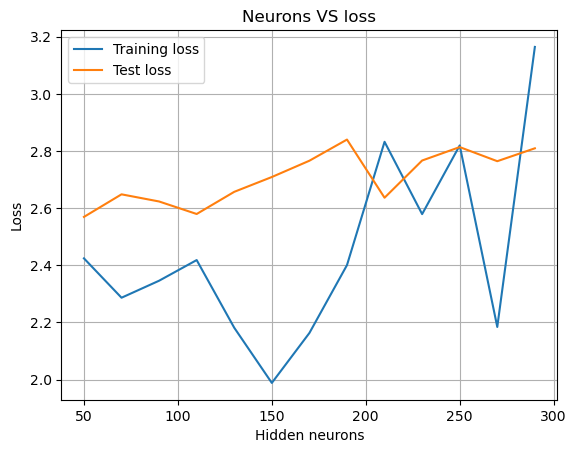

In [42]:
neurons = torch.arange(50, 300, 20)
test_losses = []
train_losses = []

for i in range(neurons.shape[0]):
    # Create embedding table
    block_size = 4
    embedding_size = 2
    lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

    # Create dataset
    xs, ys = [], []
    count = 0
    for word in words:
        # Create sequences of 'n' inputs as x and the next character as output 'y'

        # Initially all characters in input will be delimiter token and output will be the 
        # first character of the word
        context = [characters_to_index[delimiter_token] for _ in range(block_size)]
        for c in word + delimiter_token:
            output_character = characters_to_index[c]
            xs.append(context)
            ys.append(output_character)
            # Add the current character to context sequence and the next character will be the output
            context = context[1:] + [output_character]


    xs = torch.tensor(xs).to(device)
    ys = torch.tensor(ys).to(device)

    # Split train and test dataset
    indices = np.arange(xs.shape[0])
    np.random.shuffle(indices)
    train_split=0.8
    split_idx = int(xs.shape[0]*train_split)
    x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
    


    # Network parameters

    W1 = torch.randn((block_size * embedding_size, neurons[i]), requires_grad=True).to(device)
    b1 = torch.randn(neurons[i], requires_grad=True).to(device)

    W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
    b2 = torch.randn(len(characters), requires_grad=True).to(device)

    learning_rate = 0.1
    batch_size = 32
    epochs = 10_000

    parameters = [lookup_table, W1, b1, W2, b2]
    total_params = 0
    for p in parameters:
        p.retain_grad()
        total_params += p.nelement()

    # Train the network

    for _ in tqdm(range(epochs), desc=f'Neurons: {neurons[i]}'):
        # Set initial gradient of weights and biases to zero
        for p in parameters:
            p.grad = None


        # Get batch
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        # Inputs must be converted to embeddings just before the forward pass to preserve gradients
        x, y = lookup_table[x_train[idx]], y_train[idx]

        # Predict output
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y)

        # Calculate the gradients of the weight
        loss.backward()

        # Update the parameters
        for p in parameters:
            p.data += learning_rate * (-p.grad)
            
    train_losses.append(loss.item())
    # Calculate test loss
    with torch.no_grad():
        # Predict output
        x = lookup_table[x_test]
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y_test)
        test_losses.append(loss.item())
    

plt.figure()
plt.title("Neurons VS loss")
plt.xlabel("Hidden neurons")
plt.ylabel("Loss")
plt.plot(neurons, train_losses, label='Training loss')
plt.plot(neurons, test_losses, label='Test loss')
plt.grid()
plt.legend()
plt.show()

From the above graph we can see that initially as as the number of neurons increase (roughly up to 150), the loss decreases. But then as the number of neurons increase so does the loss. It is probably due to the fact that if neurons increase and the learning rate remains the same, the network takes more time to train. We need to test it by changing the learning rate with the number of neurons and then calculate the loss. Another probable reason may be vanishing gradient.

# Determining the embedding size

Now we will increase the embedding size from 2 to 30 and see how the loss changes with the increase in embedding size

ES: 29: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.49it/s]


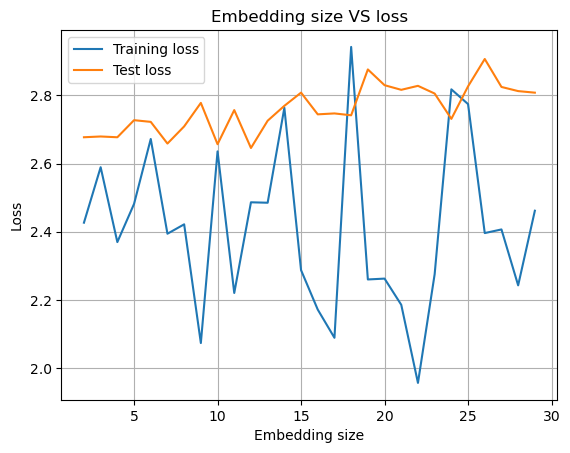

In [43]:
embedding_sizes = torch.arange(2, 30, 1)
test_losses = []
train_losses = []

for i in range(embedding_sizes.shape[0]):
    # Create embedding table
    block_size = 4
    embedding_size = embedding_sizes[i]
    lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

    # Create dataset
    xs, ys = [], []
    count = 0
    for word in words:
        # Create sequences of 'n' inputs as x and the next character as output 'y'

        # Initially all characters in input will be delimiter token and output will be the 
        # first character of the word
        context = [characters_to_index[delimiter_token] for _ in range(block_size)]
        for c in word + delimiter_token:
            output_character = characters_to_index[c]
            xs.append(context)
            ys.append(output_character)
            # Add the current character to context sequence and the next character will be the output
            context = context[1:] + [output_character]


    xs = torch.tensor(xs).to(device)
    ys = torch.tensor(ys).to(device)

    # Split train and test dataset
    indices = np.arange(xs.shape[0])
    np.random.shuffle(indices)
    train_split=0.8
    split_idx = int(xs.shape[0]*train_split)
    x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)
    


    # Network parameters

    W1 = torch.randn((block_size * embedding_size, 150), requires_grad=True).to(device)
    b1 = torch.randn(150, requires_grad=True).to(device)

    W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True).to(device)
    b2 = torch.randn(len(characters), requires_grad=True).to(device)

    learning_rate = 0.1
    batch_size = 32
    epochs = 10_000

    parameters = [lookup_table, W1, b1, W2, b2]
    total_params = 0
    for p in parameters:
        p.retain_grad()
        total_params += p.nelement()

    # Train the network

    for _ in tqdm(range(epochs), desc=f'ES: {embedding_sizes[i]}'):
        # Set initial gradient of weights and biases to zero
        for p in parameters:
            p.grad = None


        # Get batch
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        # Inputs must be converted to embeddings just before the forward pass to preserve gradients
        x, y = lookup_table[x_train[idx]], y_train[idx]

        # Predict output
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y)

        # Calculate the gradients of the weight
        loss.backward()

        # Update the parameters
        for p in parameters:
            p.data += learning_rate * (-p.grad)
            
    train_losses.append(loss.item())
    # Calculate test loss
    with torch.no_grad():
        # Predict output
        x = lookup_table[x_test]
        out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = out1 @ W2 + b2

        # Calulate the loss
        loss = F.cross_entropy(logits, y_test)
        test_losses.append(loss.item())
    

plt.figure()
plt.title("Embedding size VS loss")
plt.xlabel("Embedding size")
plt.ylabel("Loss")
plt.plot(embedding_sizes, train_losses, label='Training loss')
plt.plot(embedding_sizes, test_losses, label='Test loss')
plt.grid()
plt.legend()
plt.show()

We can see that as the embedding size increases, the loss decreases from embedding size 2 to 8. However, it starts increasing after that. Moreover, the difference between the loss of training and test set starts to increase. It is a sign of the network overfitting with our training dataset.

## Viewing the weights of hidden neurons for the largest embedding size

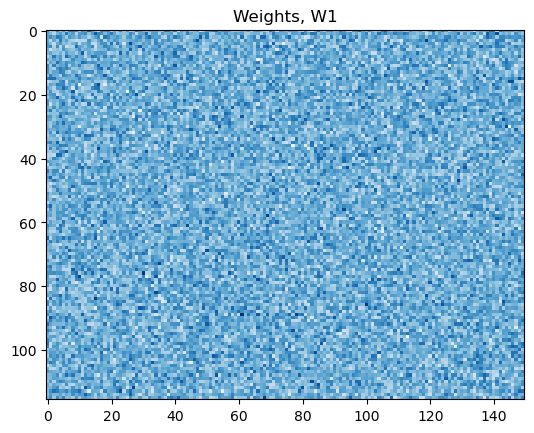

In [44]:
with torch.no_grad():
    plt.figure()
    plt.title("Weights, W1")
    plt.imshow(W1.cpu(), cmap='Blues')
    plt.show()

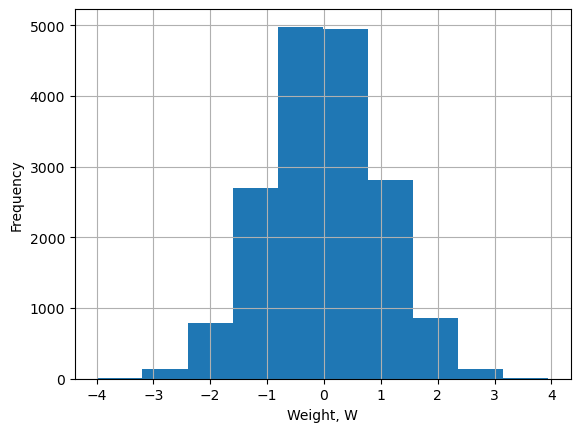

In [45]:
with torch.no_grad():
    plt.figure("Histogram of weights")
    plt.hist(W1.cpu().view(-1))
    plt.grid()
    plt.xlabel("Weight, W")
    plt.ylabel("Frequency")
    plt.show()

We can see from the above two images that the weights of the neurons are normally distributed which is a good sign.

## Viewing the output of hidden layer for the largest embedding size

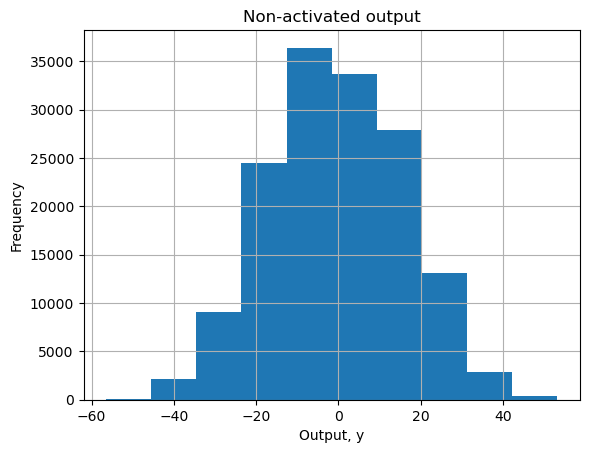

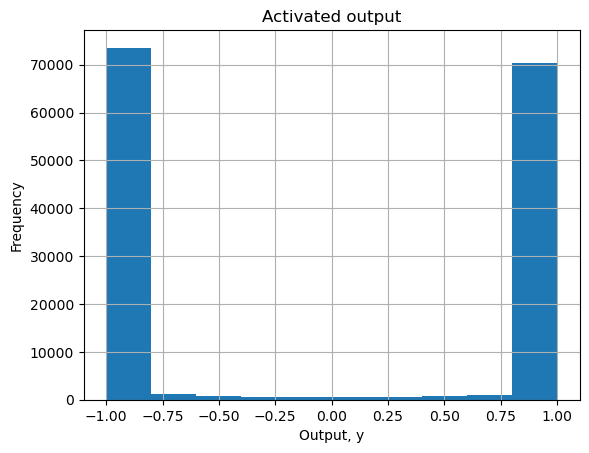

In [46]:
with torch.no_grad():
    x = lookup_table[x_test[:1000]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Non-activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(non_activated.cpu().view(-1))
    plt.grid()
    plt.show()

    plt.figure()
    plt.title("Activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(activated.cpu().view(-1))
    plt.grid()
    plt.show()

We can see from the above graphs that the activated output of the hidden neurons peak at -1 and 1. It means that the tanh function is very active. This happens because the non-activated output has a wide distribution i.e. a high variance.

In [47]:
with torch.no_grad():
    print(torch.var(non_activated.cpu()))

tensor(264.0609)


Here, the variance is very high. As a result, tanh function converts most of the output to 1 and -1. The equation of a tanh function is:

\begin{equation}
tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
\end{equation}

The derivative of the tanh function is:

\begin{equation}
\frac{d}{dx}tanh(x) = (1 - tanh(x)^2) * Gradient_{output}
\end{equation}

Therefore during backpropagation, if the value of tanh is close to 1 or -1, the value $1 - tanh(x)^2$ becomes close to zero. The gradient multiplied by a value close to zero is almost zero. Therefore, the gradients do not flow backward to the weights and reduces the performance of the neurons. This problem is known as the **vanishing gradient** problem.

Let us view the neurons that provided an activation output close to 1 or -1.

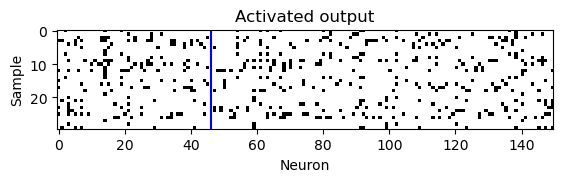

In [48]:
with torch.no_grad():
    x = lookup_table[x_test[:30]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Activated output")
    plt.imshow(activated.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')
    plt.xlabel("Neuron")
    plt.ylabel("Sample")
    for i in range(activated.shape[1]):
        if activated.shape[0] - activated[:, i].abs().sum() < 1e-9:
            plt.axvline(x=i, color='blue')
    plt.show()

We can see that most of the neurons provide an activated output which is close to 1 or -1. Here, the row indicates the number of neurons and the column indicates the number of samples in the batch. If any column in the image is completely white, it means that the neuron in that x-axis always provides an output close to 1. Therefore, during backpropagation the gradients do not flow through that neuron. These type of neurons are known as **dead neuron**. In the above diagram, the neurons along the blue lines are dead neurons and the weights of those neurons are never updated. Therefore, these neurons do not contribute to the output of the network. We want to avoid this problem.

To solve this problem we want the non-activated outputs to be closer to zero. In that case the output of the tanh or other non-linear activation will contain less amount of peaked outputs. We can use the following methods to solve the problem:

### 1. Set the weights and biases of the neurons close to zero during the initialization.

In [49]:
# Create embedding table
block_size = 4
embedding_size = 29
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'

    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)

# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)



# Network parameters - Set the weights and biases close to zero
W1 = np.random.normal(size=(block_size * embedding_size, 150)) * 0.02
W1 = torch.tensor(W1, requires_grad=True, device=device).float()

b1 = np.random.normal(size=150) * 0.001
b1 = torch.tensor(b1, requires_grad=True, device=device).float()

W2 = np.random.normal(size=(W1.shape[1], len(characters))) * 0.001
W2 = torch.tensor(W2, requires_grad=True, device=device).float()

b2 = np.random.normal(size=len(characters)) * 0
b2 = torch.tensor(b2, requires_grad=True, device=device).float()

learning_rate = 0.1
batch_size = 32
epochs = 10_000

parameters = [lookup_table, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    
    p.retain_grad()
    total_params += p.nelement()

# Train the network
cl = 0

for _ in tqdm(range(epochs), desc=f'Loss: {cl}'):
    # Set initial gradient of weights and biases to zero
    for p in parameters:
        p.grad = None


    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    # Inputs must be converted to embeddings just before the forward pass to preserve gradients
    x, y = lookup_table[x_train[idx]], y_train[idx]

    # Predict output
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y)

    # Calculate the gradients of the weight
    loss.backward()
    cl = loss.item()

    # Update the parameters
    for p in parameters:
        p.data += learning_rate * (-p.grad)


print(f"Train loss: {loss.item()}")
# Calculate test loss
with torch.no_grad():
    # Predict output
    x = lookup_table[x_test]
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y_test)
    print(f"Test loss: {loss.item()}")

Loss: 0: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 189.77it/s]


Train loss: 2.0017924308776855
Test loss: 2.400049924850464


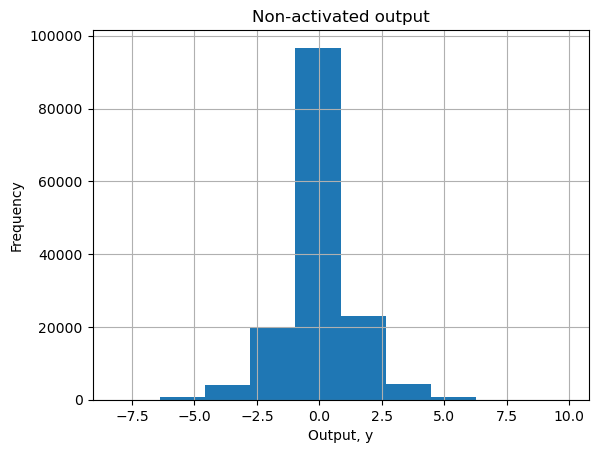

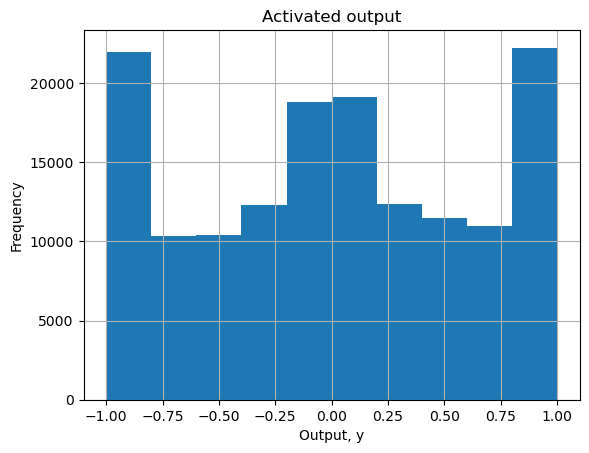

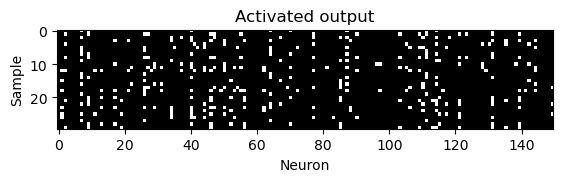

In [50]:
with torch.no_grad():
    x = lookup_table[x_test[:1000]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Non-activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(non_activated.cpu().view(-1))
    plt.grid()
    plt.show()

    plt.figure()
    plt.title("Activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(activated.cpu().view(-1))
    plt.grid()
    plt.show()
    
    x = lookup_table[x_test[:30]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Activated output")
    plt.imshow(activated.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')
    plt.xlabel("Neuron")
    plt.ylabel("Sample")
    for i in range(activated.shape[1]):
        if activated.shape[0] - activated[:, i].abs().sum() < 1e-9:
            plt.axvline(x=i, color='yellow')
    plt.show()

Since the weights and biases are close to zero, we now have a smooth distribution of the activated outputs. Furthermore, we no longer have any dead neurons. Furthermore, the train and test loss also decreased significantly.

However, instead of initializing the **weights** with magic numbers like 0.01, 0.02, etc. we can use the equation $\frac{gain}{\sqrt{n_i}}$ where $n_i$ is the fan-in or the input size of the layer and gain is a constant that varies based on the type of activation used. This is known as **kaiming normalization**. For tanh the value of gain is $\frac{5}{3*n_i}$.

In [51]:
# Create embedding table
block_size = 4
embedding_size = 29
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'

    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)

# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)



# Network parameters - Set the weights and biases close to zero using kaiming normal
W1 = np.random.normal(size=(block_size * embedding_size, 150)) * ( 5/(3 * np.sqrt(block_size * embedding_size)) ) # tanh activation
W1 = torch.tensor(W1, requires_grad=True, device=device).float()

b1 = np.random.normal(size=150)  * 0.01
b1 = torch.tensor(b1, requires_grad=True, device=device).float()

W2 = np.random.normal(size=(W1.shape[1], len(characters)))  * 0.01
W2 = torch.tensor(W2, requires_grad=True, device=device).float()

b2 = np.random.normal(size=len(characters)) * 0
b2 = torch.tensor(b2, requires_grad=True, device=device).float()

learning_rate = 0.1
batch_size = 32
epochs = 10_000

parameters = [lookup_table, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    
    p.retain_grad()
    total_params += p.nelement()

# Train the network
cl = 0

for _ in tqdm(range(epochs), desc=f'Loss: {cl}'):
    # Set initial gradient of weights and biases to zero
    for p in parameters:
        p.grad = None


    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    # Inputs must be converted to embeddings just before the forward pass to preserve gradients
    x, y = lookup_table[x_train[idx]], y_train[idx]

    # Predict output
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y)

    # Calculate the gradients of the weight
    loss.backward()
    cl = loss.item()

    # Update the parameters
    for p in parameters:
        p.data += learning_rate * (-p.grad)


print(f"Train loss: {loss.item()}")
# Calculate test loss
with torch.no_grad():
    # Predict output
    x = lookup_table[x_test]
    out1 = torch.tanh(x.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y_test)
    print(f"Test loss: {loss.item()}")

Loss: 0: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 189.63it/s]


Train loss: 2.2472479343414307
Test loss: 2.4370198249816895


The train and test loss is pretty good after this kind of normalization.

### 2. Use Batch Normalization

In this process instead of setting the weights and biases close to zero, we take the non-activated output of each layer and normalize the data so that it follows a standard normal distribution. In this way, the non-activated outputs are close to zero and the activated outputs are therefore smooth.

The equation to compute a standard normal distribution is as follows:

\begin{equation}
\hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}
\end{equation}

Here,

- $\hat{x_i}$ is the non-activated **feature** output of sample 'i' in a batch of sample where $0<i<n$. 'n' is the size of the batch.

- $\mu_B$ is mean of the mean of the **feature** outputs of the entire batch.

- $\sigma^2_B$ is the variance of the **feature** outputs of the entire batch.

- $\epsilon$ is a small constant so that the denomenator is not zero.

If we have an output array \[ \[1, 2\], \[3, 4\], \[5, 6\]  \] where the first dimension (row) contains all samples (3 samples) of the batch and the second dimension (column) contains the number of features (2 features)s per sample, the batch normalized output will be:

\begin{equation}
\mu_B = [\frac{1+3+5}{3}, \frac{2+4+6}{3}] = [3, 4] \\
\sigma^2_B = [ \frac{1}{3} * ( (1 - 3)^2 + (3-3)^2 + (5-3)^2 ),  \frac{1}{3} * ( (2 - 4)^2 + (4-4)^2 + (6-4)^2 )] = [1.33, 1.33] \\
\hat{x} = [ [ \frac{1-3}{\sqrt{1.33 + 0}}, \frac{2-4}{\sqrt{1.33 + 0}} ], [\frac{3-3}{\sqrt{1.33 + 0}}, \frac{4-4}{\sqrt{1.33 + 0}}], [\frac{5-3}{\sqrt{1.33 + 0}}, \frac{6-4}{\sqrt{1.33 + 0}}] ] \\
\hat{x} = [ [-1.73, -1.73], [0, 0], [1.73, 1.73] ]
\end{equation}

However, we only want the non-activated outputs to be Gaussian only at initialization. We want to allow the network to shift and scale the distribution so that it can prioritize some neurons when predicting an output. Therefore, we need to introduce two additional trainable parameters that will allow the network to scale and shift the output distribution based on the input. The equation to add this feature is as follows:

\begin{equation}
y_i = \gamma \hat{x_i} + \beta
\end{equation}

Here,
- $\hat{x_i}$ is the normalized output
- $\gamma$ is the scale (or gain)
- $\beta$ is the offset (or bias)



In [52]:
# Create embedding table
block_size = 4
embedding_size = 29
lookup_table = torch.randn((len(characters), embedding_size), requires_grad=True).to(device)

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'

    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs).to(device)
ys = torch.tensor(ys).to(device)

# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train, x_test, y_test = xs[:split_idx].to(device), ys[:split_idx].to(device), xs[split_idx:].to(device), ys[split_idx:].to(device)



# Network parameters
W1 = torch.randn((block_size * embedding_size, 150), requires_grad=True, device=device)
b1 = torch.randn(150, requires_grad=True, device=device)
bn1_gain = torch.ones((1, 150), requires_grad=True, device=device).float()
bn1_bias = torch.zeros((1, 150), requires_grad=True, device=device).float()

W2 = torch.randn((W1.shape[1], len(characters)), requires_grad=True, device=device)
b2 = torch.randn(len(characters), requires_grad=True, device=device)

learning_rate = 0.1
batch_size = 32
epochs = 10_000

parameters = [lookup_table, W1, b1, bn1_gain, bn1_bias, W2, b2]
total_params = 0
for p in parameters:
    
    p.retain_grad()
    total_params += p.nelement()

# Train the network
cl = 0
bn1_means = torch.zeros_like(bn1_gain, device=device).float()
bn1_variances = torch.zeros_like(bn1_gain, device=device).float()

for _ in tqdm(range(epochs), desc=f'Loss: {cl}'):
    # Set initial gradient of weights and biases to zero
    for p in parameters:
        p.grad = None


    # Get batch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    # Inputs must be converted to embeddings just before the forward pass to preserve gradients
    x, y = lookup_table[x_train[idx]], y_train[idx]

    # Predict output
    non_activated_output = x.view(-1, block_size * embedding_size) @ W1 + b1
    
    # Batch normalization
    mean = non_activated_output.mean(0, keepdim=True)
    var = non_activated_output.var(0, keepdim=True)
    
    # Calculate running mean and variance
    with torch.no_grad():
        bn1_means = 0.999 * bn1_means + 0.001 * mean
        bn1_variances = 0.999 * bn1_variances + 0.001 * var
    

    non_activated_output = (non_activated_output - mean)/torch.sqrt(var + 1e-9)
    non_activated_output = bn1_gain * non_activated_output + bn1_bias
    out1 = torch.tanh(non_activated_output)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y)

    # Calculate the gradients of the weight
    loss.backward()
    cl = loss.item()

    # Update the parameters
    for p in parameters:
        p.data += learning_rate * (-p.grad)


print(f"Train loss: {loss.item()}")
# Calculate test loss
with torch.no_grad():
    # Predict output
    x = lookup_table[x_test]
    non_activated_output = x.view(-1, block_size * embedding_size) @ W1 + b1
    
    non_activated_output = (non_activated_output - bn1_means)/torch.sqrt(bn1_variances + 1e-9)
    non_activated_output = bn1_gain * non_activated_output + bn1_bias
    out1 = torch.tanh(non_activated_output)
    logits = out1 @ W2 + b2

    # Calulate the loss
    loss = F.cross_entropy(logits, y_test)
    print(f"Test loss: {loss.item()}")

Loss: 0: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 180.26it/s]

Train loss: 2.7645576000213623
Test loss: 2.544687271118164


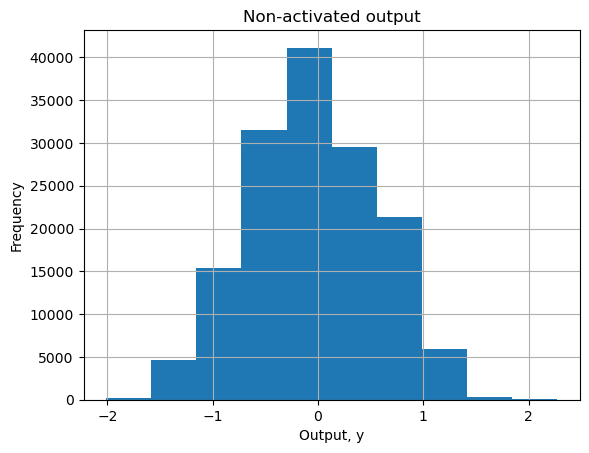

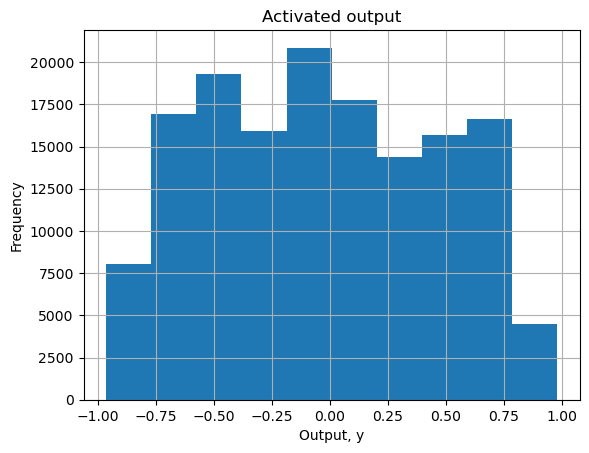

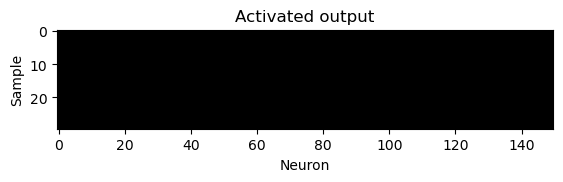

In [53]:
with torch.no_grad():
    
    x = lookup_table[x_test[:1000]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    non_activated = (non_activated - bn1_means)/torch.sqrt(bn1_variances + 1e-9)
    non_activated = bn1_gain * non_activated + bn1_bias
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Non-activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(non_activated.cpu().view(-1))
    plt.grid()
    plt.show()

    plt.figure()
    plt.title("Activated output")
    plt.xlabel("Output, y")
    plt.ylabel("Frequency")
    plt.hist(activated.cpu().view(-1))
    plt.grid()
    plt.show()
    
    x = lookup_table[x_test[:30]]
    non_activated = x.view(-1, block_size * embedding_size) @ W1 + b1
    non_activated = (non_activated - bn1_means)/torch.sqrt(bn1_variances + 1e-9)
    non_activated = bn1_gain * non_activated + bn1_bias
    activated = torch.tanh(non_activated)
    
    plt.figure()
    plt.title("Activated output")
    plt.imshow(activated.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')
    plt.xlabel("Neuron")
    plt.ylabel("Sample")
    for i in range(activated.shape[1]):
        if activated.shape[0] - activated[:, i].abs().sum() < 1e-9:
            plt.axvline(x=i, color='yellow')
    plt.show()

Using Batch normalization we also get a smooth activated output and no dead neurons. This helps with the issue of vanishing gradients.

**If we have a shallow network with few layers, we use the 'weight initialization' technique to normalize the outputs. But when the network is deep and has many layers we usually use 'batch normalization' after most layers (e.g. linear layer, convolutional layer, etc.) to normalize the output.**

**Batch normalization couples the samples of the batch because it calculates mean over the entire batch. Therefore, it should be avoided as much as possible.**

In [54]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(tuple(range(len(x.shape)-1)), keepdim=True) # compute mean over the last dimension only
            xvar = x.var(tuple(range(len(x.shape)-1)), keepdim=True) # compute variance over the last dimension only
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [55]:

n_embd = 29 # the dimensionality of the character embedding vectors
n_hidden = 150 # the number of neurons in the hidden layer of the MLP
vocab_size = len(characters)
block_size = 4
# g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), device=device)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

113787


In [56]:
# same optimization as last time
max_steps = 10_000
batch_size = 32
lossi = []
ud = []
    
for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), device=device)
    Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.3096


# Network Diagnostic Tools

layer 2 (      Tanh): mean +0.00, std 0.65, saturated: 4.46%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 3.83%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 3.00%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 2.71%
layer 14 (      Tanh): mean -0.00, std 0.67, saturated: 2.04%


Text(0.5, 1.0, 'activation distribution')

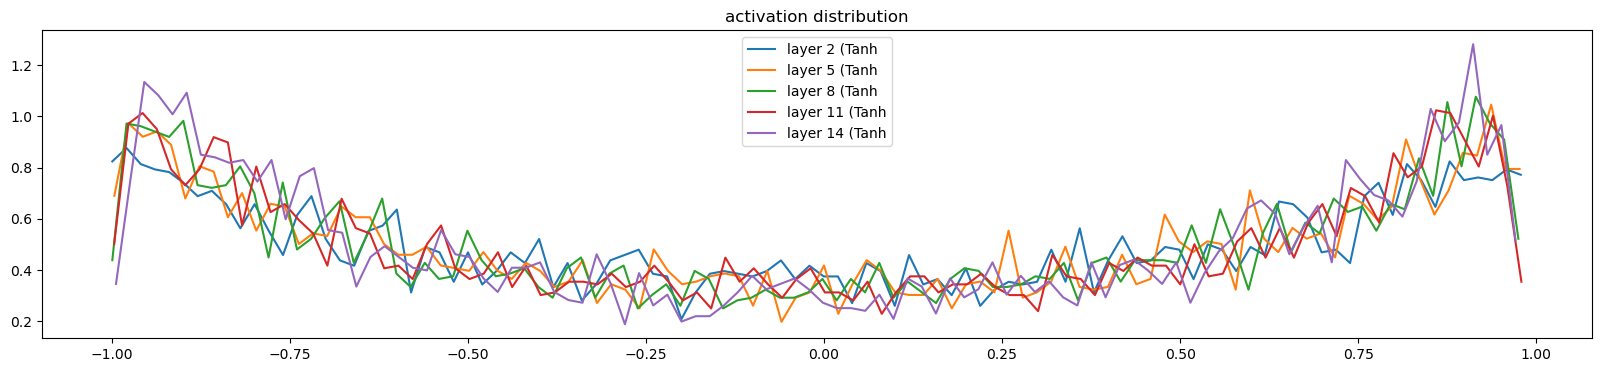

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.088895e-03
layer 5 (      Tanh): mean +0.000000, std 1.961153e-03
layer 8 (      Tanh): mean +0.000000, std 1.821989e-03
layer 11 (      Tanh): mean -0.000000, std 1.678133e-03
layer 14 (      Tanh): mean -0.000000, std 1.749837e-03


Text(0.5, 1.0, 'gradient distribution')

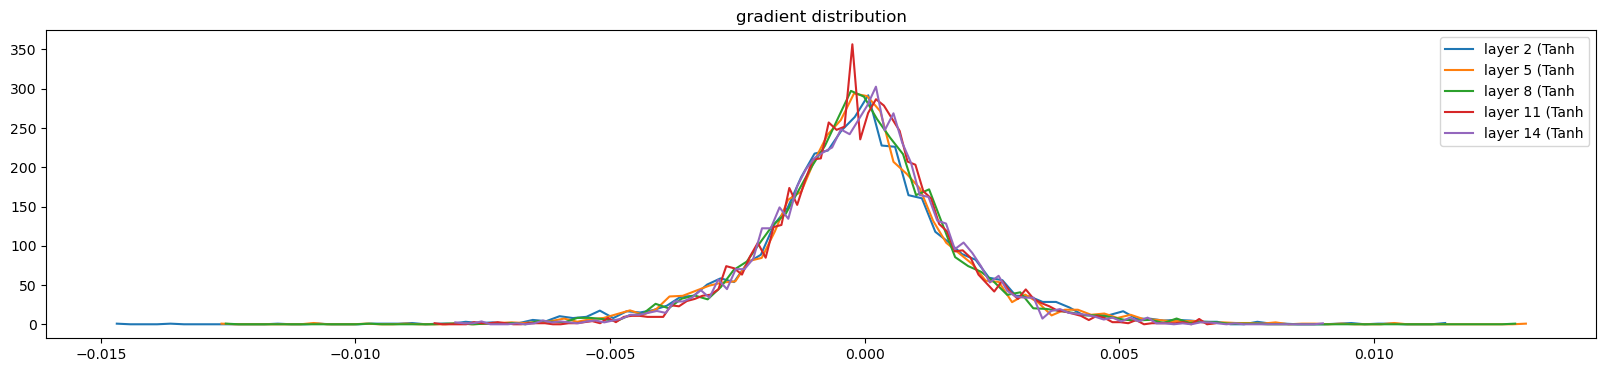

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 29) | mean +0.000000 | std 5.799538e-03 | grad:data ratio 5.634170e-03
weight (116, 150) | mean +0.000028 | std 6.208009e-03 | grad:data ratio 5.410181e-02
weight (150, 150) | mean +0.000027 | std 4.745843e-03 | grad:data ratio 4.980637e-02
weight (150, 150) | mean +0.000029 | std 4.418174e-03 | grad:data ratio 4.742147e-02
weight (150, 150) | mean +0.000033 | std 4.036700e-03 | grad:data ratio 4.413807e-02
weight (150, 150) | mean -0.000018 | std 3.619468e-03 | grad:data ratio 4.032369e-02
weight  (150, 27) | mean +0.000076 | std 8.812613e-03 | grad:data ratio 7.142733e-02


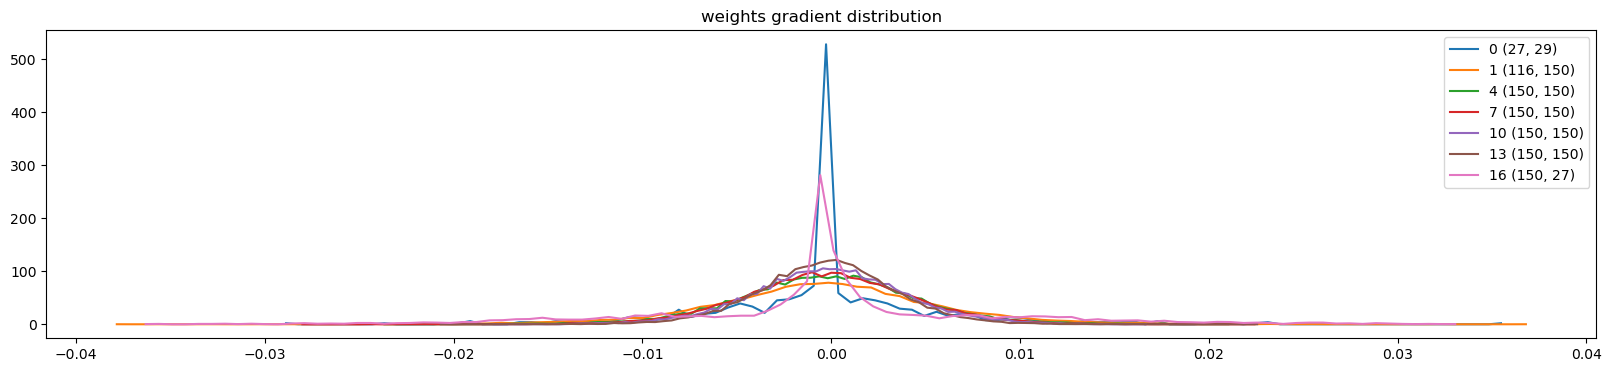

In [59]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

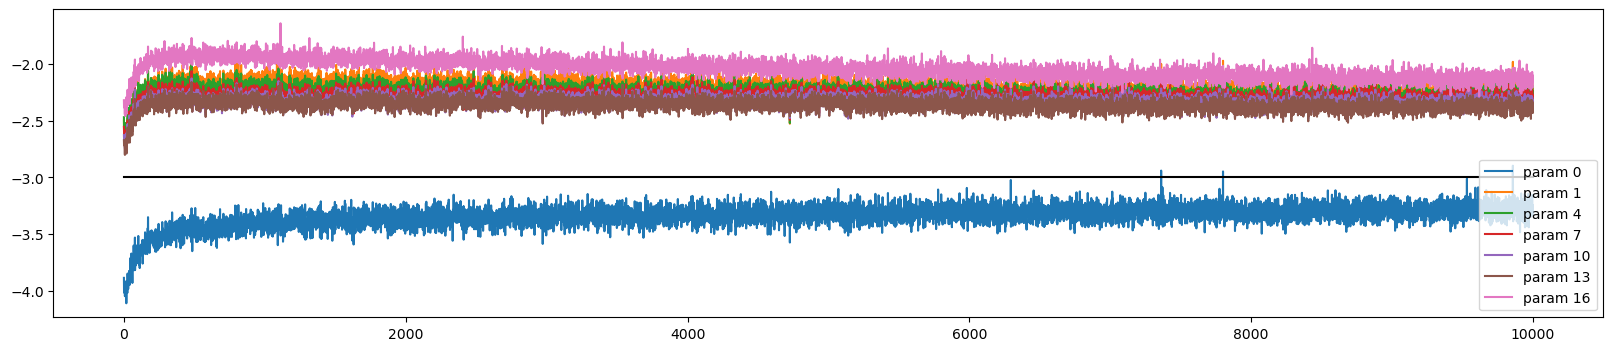

In [60]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


# Create Network using Layers

In [61]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim), device=device) # voacb size, embedding_size
        
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
        
    def parameters(self):
        return [self.weight]
    

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
        
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## 1. Prepare Dataset

In [62]:
block_size = 4

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'

    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs, device=device)
ys = torch.tensor(ys, device=device)

# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train = xs[:split_idx].to(device), ys[:split_idx].to(device)
x_test, y_test = xs[split_idx:].to(device), ys[split_idx:].to(device)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train[:10])

torch.Size([182516, 4]) torch.Size([182516]) torch.Size([45630, 4]) torch.Size([45630])
tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0, 15],
        [ 0,  0, 15, 12],
        [ 0, 15, 12,  9],
        [15, 12,  9, 22]], device='cuda:0')


## 2. Create Network

In [63]:
embedding_size = 10
vocab_size = len(characters)
hidden_neurons = 200

model = Sequential([
    Embedding(vocab_size, embedding_size),
    Flatten(),
    Linear(block_size*embedding_size, hidden_neurons, bias=False),
    BatchNorm1d(hidden_neurons),
    Tanh(),
    Linear(hidden_neurons, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # The weights of last layer should be close to zero at initialization
    
print(f"Total parameters: {sum(p.nelement() for p in model.parameters())}")
for p in model.parameters():
    p.requires_grad = True

Total parameters: 14097


## 3. Train the network

In [64]:
epochs = 100_000
batch_size = 32
learning_rate = 0.1
lossi = []

# Enable training mode
for layer in model.layers:
    layer.training = True

for i in tqdm(range(epochs)):
    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), device=device)
    Xb, Yb = x_train[ix], y_train[ix] # batch X,Y
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backpropagation
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # Update weight
    for p in model.parameters():
        p.data += -learning_rate * p.grad
        
    # Learning rate decay
    if (i > epochs/2) and (i % 100 == 0) and (learning_rate > 0.01):
        learning_rate -= 0.001
        
    lossi.append(loss.log10().item())

print(f"Final train loss: {lossi[-1]}")

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:14<00:00, 740.92it/s]

Final train loss: 0.2113897204399109


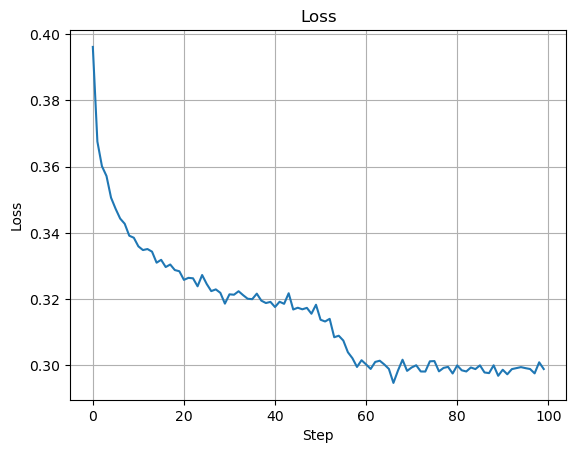

In [65]:
plt.figure()
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.grid()
plt.show()

## 4. Calculate Test loss

In [66]:
@torch.no_grad()
def calculate_loss(x, y, model):
    # Disable training mode
    for layer in model.layers:
        layer.training = False
        
    logits = model(x)
    return F.cross_entropy(logits, y)
print(f"Train loss: {calculate_loss(x_train, y_train, model).item()}")
print(f"Test loss: {calculate_loss(x_test, y_test, model).item()}")

Train loss: 1.967180609703064
Test loss: 2.2992913722991943


## 5. Generate Names

In [67]:
@torch.no_grad()
def generate_name(model, block_size, characters, characters_to_index, delimiter_token='.', total_names=1):
    # Disable training mode
    for layer in model.layers:
        layer.training = False
        
    names = []
    for i in range(total_names):
        name = []
        context = [characters_to_index[delimiter_token]] * block_size
        
        while True:
            logits = model(torch.tensor([context], device=device))
            probabilities = F.softmax(logits, dim=1)
            predicted_character = torch.multinomial(probabilities, num_samples=1).item()
            context = context[1:] + [predicted_character]
            
            if characters[predicted_character] == delimiter_token:
                break
            else:
                name.append(characters[predicted_character])
        names.append(''.join(name))
        
    return names
        

print(generate_name(model, block_size, characters, characters_to_index, delimiter_token, 20))

['john', 'elliena', 'keavyna', 'wisoh', 'kamun', 'anna', 'abeace', 'adiyocir', 'malid', 'jaswyn', 'henda', 'amea', 'kallee', 'vion', 'jarilin', 'matt', 'dara', 'namielia', 'lara', 'sandrua']


# WaveNet

Inititally we had a block size of 8 and embedding size of 10. So, the input was of the shape (batch size, 8, 10). When we were performing computation, all the 8 characters were being computed together to provide an output of the hidden layer. But in WaveNet architecture we group the consecutive characters where each group contains 2 consecutive characters.

Example:

Input: \[A, B, C, D, E, F, G, H\]

Layer 1: \[(A,B) @ W1 => 1, (C,D) @ W1 => 2, (E, F) @ W1 => 3, (G,H) @ W1 => 4 \]

Layer 2: \[(1,2) @ W2 => 5, (3,4) @ W2 => 6 \]

Layer 3 \[(5,6) @ W3 \]

In the above way we group each character and compute forward pass. We then again pair the next two consecutive outputs and compute forward pass for the next layer. We continue this until we reach the last layer. This enables us to capture information from two consecutive bigrams and slowly merge the information instead of computing the output in a single pass.

In [68]:
class FlattenConsecutive:
    """
    It flattens out by grouping 'n' consecutive elements in the vector
    """
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []

## 1. Create Dataset

In [69]:
block_size = 8

# Create dataset
xs, ys = [], []
count = 0
for word in words:
    # Create sequences of 'n' inputs as x and the next character as output 'y'

    # Initially all characters in input will be delimiter token and output will be the 
    # first character of the word
    context = [characters_to_index[delimiter_token] for _ in range(block_size)]
    for c in word + delimiter_token:
        output_character = characters_to_index[c]
        xs.append(context)
        ys.append(output_character)
        # Add the current character to context sequence and the next character will be the output
        context = context[1:] + [output_character]


xs = torch.tensor(xs, device=device)
ys = torch.tensor(ys, device=device)

# Split train and test dataset
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
train_split=0.8
split_idx = int(xs.shape[0]*train_split)
x_train, y_train = xs[:split_idx].to(device), ys[:split_idx].to(device)
x_test, y_test = xs[split_idx:].to(device), ys[split_idx:].to(device)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train[:10])

torch.Size([182516, 8]) torch.Size([182516]) torch.Size([45630, 8]) torch.Size([45630])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  0,  0,  5, 13, 13],
        [ 0,  0,  0,  0,  5, 13, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 15],
        [ 0,  0,  0,  0,  0,  0, 15, 12],
        [ 0,  0,  0,  0,  0, 15, 12,  9],
        [ 0,  0,  0,  0, 15, 12,  9, 22]], device='cuda:0')


## 2. Create Network

In [70]:
embedding_size = 10
vocab_size = len(characters)
hidden_neurons = 52 # Used 53 instead of 200 to keep the total number of parameters roughly the same for the previous network
number_of_consecutive_bigrams_to_group = 2

model = Sequential([
    Embedding(vocab_size, embedding_size), # Input: [b, 8], Output: [b, 8, 10]
    
    # group the value of two consecutive characters: 1st Grouping
    FlattenConsecutive(number_of_consecutive_bigrams_to_group), # Input: [b, 8, 10], Output: [b, 8/2, 10*2] = [b, 4, 20]
    
    Linear(number_of_consecutive_bigrams_to_group*embedding_size, hidden_neurons, bias=False), # Input: [b, 4, 20], Output: [b, 4, 200]
    BatchNorm1d(hidden_neurons), # Input: [b, 4, 200], Output: [b, 4, 200]
    Tanh(), # Input: [b, 4, 200], Output: [b, 4, 200]
    
    
    # group the value of two consecutive characters: 2nd Grouping
    FlattenConsecutive(number_of_consecutive_bigrams_to_group), # Input: [b, 4, 200], Output: [b, 4/2, 200*2] = [b, 2, 400]
    
    Linear(number_of_consecutive_bigrams_to_group*hidden_neurons, hidden_neurons, bias=False), # Input: [b, 2, 400], Output: [b, 2, 200]
    BatchNorm1d(hidden_neurons), # Input: [b, 2, 200], Output: [b, 2, 200]
    Tanh(), # Input: [b, 2, 200], Output: [b, 2, 200]
    
    # group the value of two consecutive characters: 3rd Grouping
    FlattenConsecutive(number_of_consecutive_bigrams_to_group), # Input: [b, 2, 200], Output: [b, 2/2, 200*2] = [b, 1, 400] = [b,400]
    
    Linear(number_of_consecutive_bigrams_to_group*hidden_neurons, hidden_neurons, bias=False), # Input: [b, 400], Output: [b, 200]
    BatchNorm1d(hidden_neurons), # Input: [b, 200], Output: [b, 200]
    Tanh(), # Input: [b, 200], Output: [b, 200]
    
    # Output layer
    Linear(hidden_neurons, vocab_size) # Input: [b, 200], Output: [b, 27]
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # The weights of last layer should be close to zero at initialization
    
print(f"Total parameters: {sum(p.nelement() for p in model.parameters())}")
for p in model.parameters():
    p.requires_grad = True

Total parameters: 13869


In [71]:
# View the output shapes
calculate_loss(x_train[:10], y_train[:10], model) # Some random output created in the model through forward pass
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (10, 8, 10)
FlattenConsecutive : (10, 4, 20)
Linear : (10, 4, 52)
BatchNorm1d : (10, 4, 52)
Tanh : (10, 4, 52)
FlattenConsecutive : (10, 2, 104)
Linear : (10, 2, 52)
BatchNorm1d : (10, 2, 52)
Tanh : (10, 2, 52)
FlattenConsecutive : (10, 104)
Linear : (10, 52)
BatchNorm1d : (10, 52)
Tanh : (10, 52)
Linear : (10, 27)


## 3. Train the network

In [72]:
epochs = 100_000
batch_size = 32
learning_rate = 0.1
lossi = []

# Enable training mode
for layer in model.layers:
    layer.training = True

for i in tqdm(range(epochs)):
    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), device=device)
    Xb, Yb = x_train[ix], y_train[ix] # batch X,Y
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backpropagation
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # Update weight
    for p in model.parameters():
        p.data += -learning_rate * p.grad
        
    # Learning rate decay
    if (i > epochs/2) and (i % 100 == 0) and (learning_rate > 0.01):
        learning_rate -= 0.001
        
    lossi.append(loss.log10().item())

print(f"Final train loss: {lossi[-1]}")

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:15<00:00, 391.66it/s]

Final train loss: 0.2799749970436096


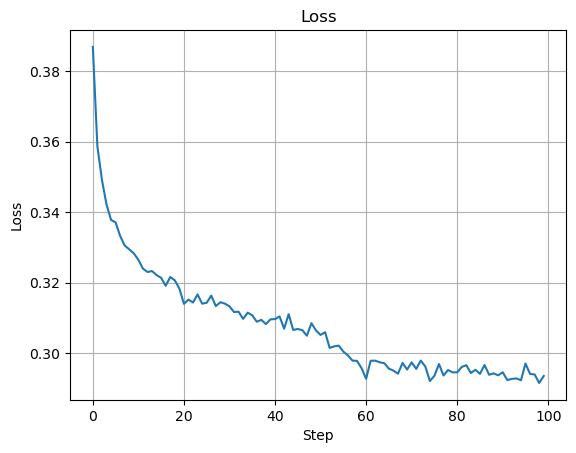

In [73]:
plt.figure()
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.grid()
plt.show()

## 4. Calculate test loss

In [74]:
print(f"Train loss: {calculate_loss(x_train, y_train, model).item()}")
print(f"Test loss: {calculate_loss(x_test, y_test, model).item()}")

Train loss: 1.953560709953308
Test loss: 2.283864736557007


## 5. Generate Names

In [75]:
print(generate_name(model, block_size, characters, characters_to_index, delimiter_token, 20))

['avitly', 'lila', 'tenika', 'anataiwe', 'vegnn', 'payben', 'toluna', 'zoahaa', 'daza', 'leonis', 'jaima', 'korsh', 'nyeise', 'marai', 'jaceod', 'janelis', 'taygen', 'brenthan', 'ailynn', 'ermella']


**One-shot model performance:**

- Train loss: ~1.96
- Test loss: ~2.29
- Train time: ~2 minutes 30 seconds

**WaveNet model performance:**

- Train loss: ~1.95
- Test loss: ~2.28
- Train time: ~4 minutes 30 seconds

We can see that using the WaveNet model, our train and test loss decreased a little. However, for WaveNet we kept the number of parameters same by decreasing the size of each layer and increasing the depth of the network. As a result, during backpropagation gradients needs to be computed for more layers sequentially. Therefore, the training time increased significantly.

**The implementation of WaveNet ends here. We can see that WaveNet only restructures the input so that the computation of forward pass is performed in group rather than in one shot.**

## References:

1. [YouTube: Neural Networks - Zero to Hero](https://youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)